In [1]:
import time
import logging
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sys.path.append('..\..')

from data_pipeline_api import standard_api

from simple_network_sim import network_of_populations as ss
from simple_network_sim import inference as inf
from simple_network_sim import loaders
from simple_network_sim.sampleUseOfModel import runSimulation, aggregateResults


store = standard_api.StandardAPI("../../config_inference.yaml", uri="", git_sha="")

def get_network():
    network = ss.createNetworkOfPopulation(
        store.read_table("human/compartment-transition", "compartment-transition"),
        store.read_table("human/population", "population"),
        store.read_table("human/commutes", "commutes"),
        store.read_table("human/mixing-matrix", "mixing-matrix"),
        store.read_table("human/infectious-compartments", "infectious-compartments"),
        store.read_table("human/infection-probability", "infection-probability"),
        store.read_table("human/initial-infections", "initial-infections"),
        store.read_table("human/trials", "trials"),
        store.read_table("human/start-end-date", "start-end-date"),
        store.read_table("human/movement-multipliers", "movement-multipliers"),
        store.read_table("human/stochastic-mode", "stochastic-mode"),
        store.read_table("human/random-seed", "random-seed"),
    )

    return network


def aggregate_all_boards(results):
    return results.output.groupby(["date", "state"]).sum().reset_index().pivot(index="date", columns="state", values="total")


def plot_posterior_abc_smc(name, unit, get_param, get_mean, summary):
    mean = get_mean(summary["particles"][0])
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 12))

    for iter, iter_stats in summary["fit_statistics"].items():
        parameter = [get_param(p) for p in iter_stats["particles"]]
        sns.kdeplot(parameter, label=iter, ax=axes[0, 0], shade=True)
        axes[0, 0].set_xlabel(unit)
        axes[0, 0].set_title(f"{name} pdf")
        
    axes[0, 0].axvline(x=mean, color="black", linestyle="--", label="prior mean")
    axes[0, 0].legend(title="SMC iteration")

    for iter, iter_stats in summary["fit_statistics"].items():
        parameter = [get_param(p) for p in iter_stats["particles"]]
        axes[0, 1].hist(parameter, bins=10, label=iter, alpha=0.5)
        axes[0, 1].set_xlabel(unit)
        axes[0, 1].set_title(f"{name} histogram")
        
    axes[0, 1].axvline(x=mean, color="black", linestyle="--", label="prior mean")
    axes[0, 1].legend(title="SMC iteration")

    parameter = [get_param(p) for p in summary["particles"]]
    sns.distplot(parameter, hist=True, kde=True, bins=8, color='darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=axes[0, 2])
    axes[0, 2].set_xlabel(unit)
    axes[0, 2].set_title(f"{name} posterior pdf")
    axes[0, 2].axvline(x=mean, color="black", linestyle="--", label="prior mean")
    axes[0, 2].legend()

    for iter, iter_stats in summary["fit_statistics"].items():
        parameter = [get_param(p) for p in iter_stats["particles"]]
        axes[1, 0].scatter(np.array(parameter) * 0 + iter, parameter)
        axes[1, 0].set_xlabel("SMC iteration")
        axes[1, 0].set_ylabel(unit)
        axes[1, 0].set_title(f"{name} scatter")
        axes[1, 0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    axes[1, 0].axhline(y=mean, color="black", linestyle="--", label="prior mean")
    axes[1, 0].legend()

    for iter, iter_stats in summary["fit_statistics"].items():
        parameter = [get_param(p) for p in iter_stats["particles"]]
        axes[1, 1].scatter([iter], stats.iqr(parameter))
        axes[1, 1].set_xlabel("SMC iteration")
        axes[1, 1].set_ylabel(unit)
        axes[1, 1].set_title(f"{name} 75% interquantile range")
        axes[1, 1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    axes[1, 2].remove()

fail_on_hash_mismatch = False


# Priors

- Prior on infection probability: Beta distribution with parameters such that mean is 0.05 and enough dispersion around it
- Prior on initial infections: Lognormal distribution with matching mean (from data pipeline), and stddev at $min(0.2*mean, 10)$, so that the dispersion is adaptive to the number of people in each region, while flooring uncertainty.

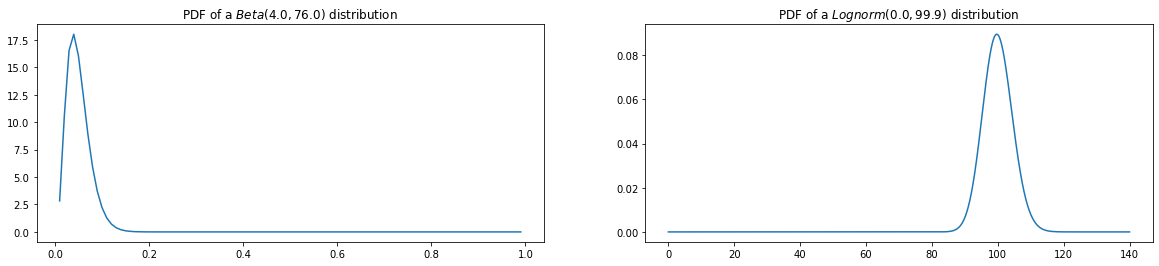

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

location = 4
mean = 0.05
x = np.arange(0.01, 1, 0.01)
y = stats.beta.pdf(x, location, location * (1 - mean) / mean)
axes[0].plot(x, y);
axes[0].set_title(f"PDF of a $Beta({location:.1f}, {location * (1 - mean) / mean:.1f})$ distribution")

mean = 100.
var = 20.
sigma = np.sqrt(np.log(1 + (var / mean**2)))
mu = np.log(mean / np.sqrt(1 + (var / mean**2)))
x = np.arange (0.01, mean + 2 * var, 0.01)
y = stats.lognorm(s=sigma, loc=0., scale=np.exp(mu)).pdf(x)
axes[1].plot(x, y);
axes[1].set_title(f"PDF of a $Lognorm({sigma:.1f}, {np.exp(mu):.1f})$ distribution");

# ABC SMC

In [3]:
store.read_table("human/abcsmc-parameters", "abcsmc-parameters")

,Parameter,Value
0,n_smc_steps,5.0
1,n_particles,100.0
2,infection_probability_shape,4.0
3,infection_probability_kernel_sigma,0.1
4,initial_infections_stddev,0.2
5,initial_infections_stddev_min,10.0
6,initial_infections_kernel_sigma,5.0


In [4]:
%%time
summary = inf.run_inference("../../config_inference.yaml")

fail_on_hash_mismatch = False


Wall time: 1h 29min 2s


Run time: 1.48h


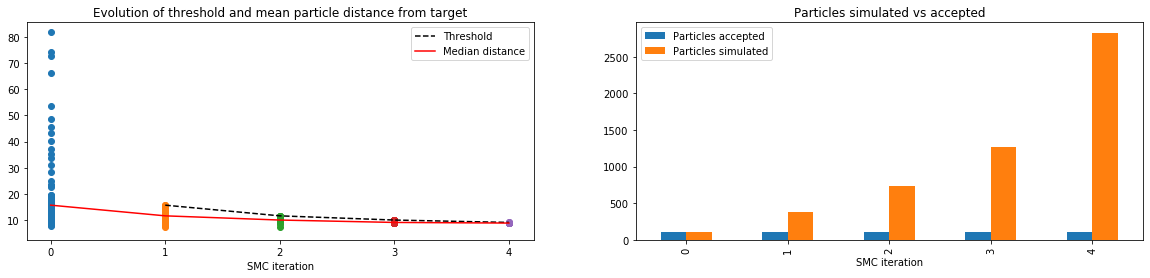

In [5]:
time = summary["time"] / 60 / 60
print(f"Run time: {time:.2f}h")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

# Distances vs threshold
for iter, iter_stats in summary["fit_statistics"].items():
    distances = iter_stats["distances"]
    axes[0].scatter(np.array(distances) * 0 + iter, distances)

distances = pd.DataFrame({k: v["distances"] for k, v in summary["fit_statistics"].items()})
thresholds = pd.DataFrame([{k: v["threshold"] for k, v in summary["fit_statistics"].items()}])
thresholds.T[0].plot(ax=axes[0], label="Threshold", title="Evolution of threshold and mean particle distance from target", color="black", linestyle="--")
distances.median().plot(ax=axes[0], label="Median distance", color="red")
axes[0].set_xlabel("SMC iteration")
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].legend();

# Particle count
particle_count = pd.DataFrame([{"SMC iteration": k, "Particles accepted": v["particles_accepted"], "Particles simulated": v["particles_simulated"]} for k, v in summary["fit_statistics"].items()]).set_index("SMC iteration")
particle_count.plot.bar(ax=axes[1])
axes[1].set_title("Particles simulated vs accepted");

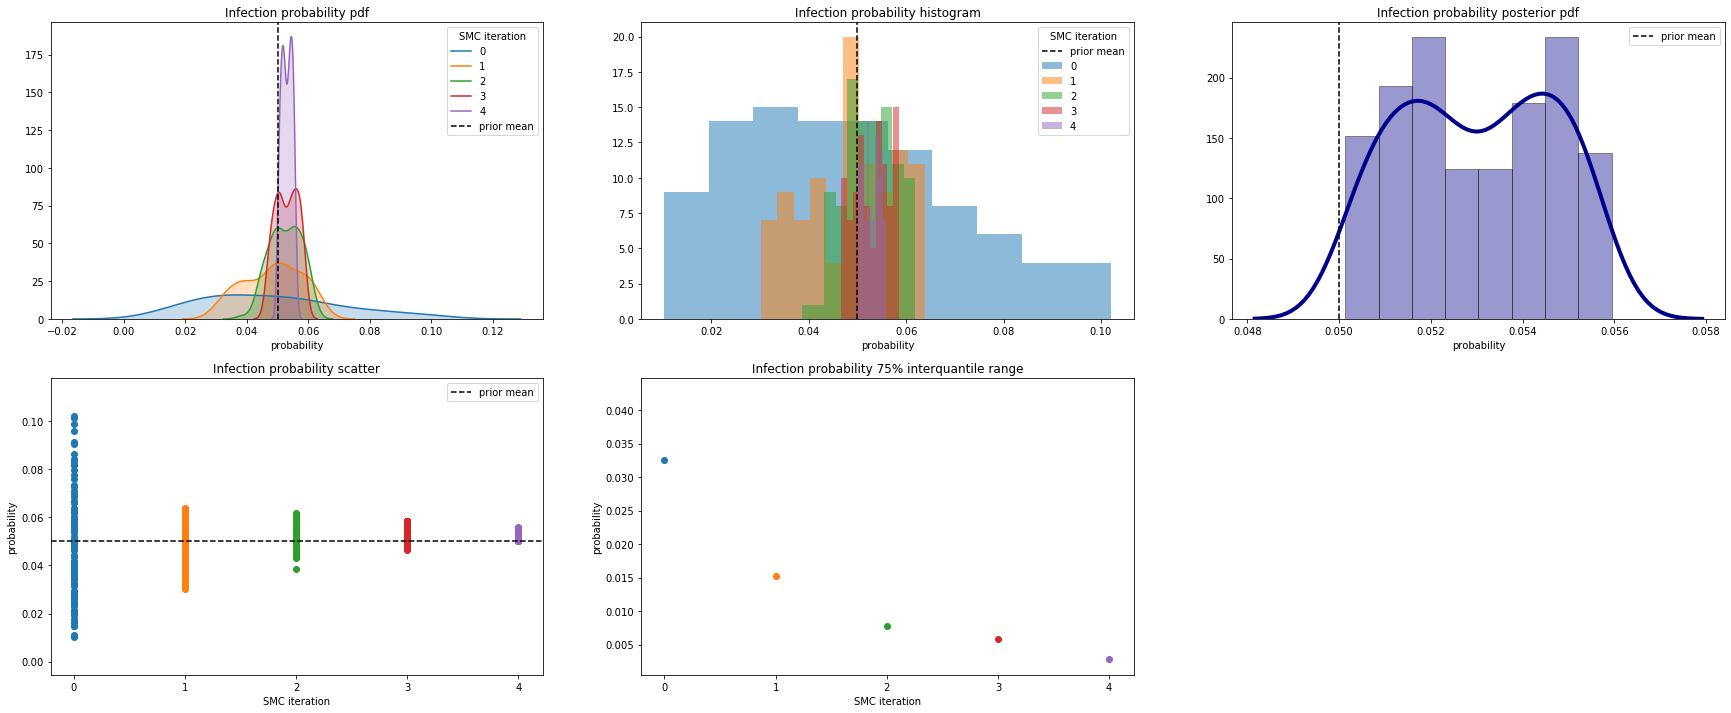

In [6]:
name = "Infection probability"
unit = "probability"
get_param_infection_proba = lambda p: p.inferred_variables["infection_probability"].value.at[0, "Value"]
get_mean_infection_proba = lambda p: p.inferred_variables["infection_probability"].mean

plot_posterior_abc_smc(name, unit, get_param_infection_proba, get_mean_infection_proba, summary)

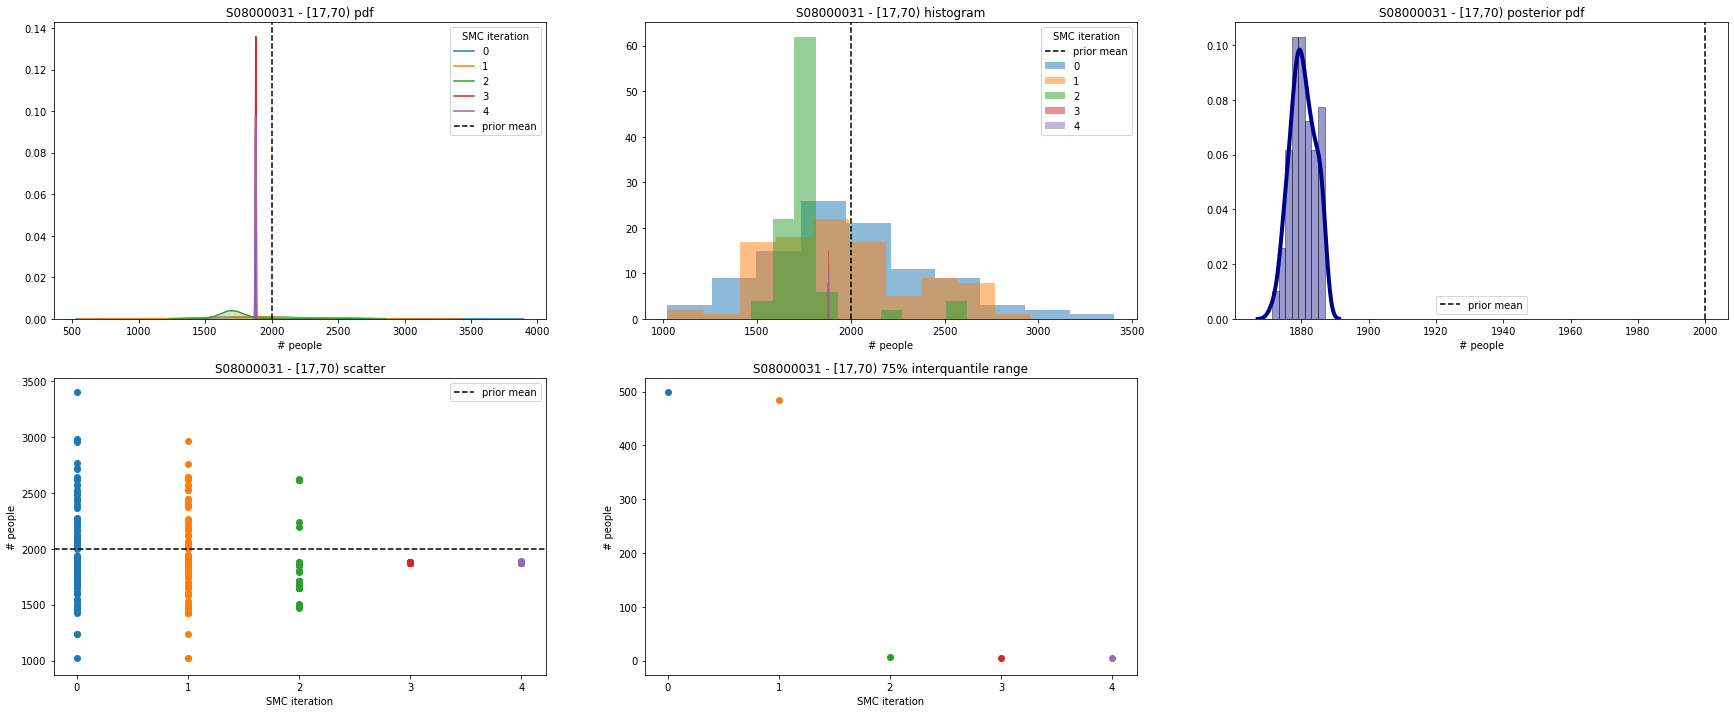

In [7]:
hb = "S08000031"
name = f"{hb} - [17,70)"
unit = "# people"
get_param_initial_infections = lambda h: (lambda p: p.inferred_variables["initial-infections"].value.query(f"Health_Board == '{h}'").Infected.values[0])
get_mean_initial_infections = lambda p: p.inferred_variables["initial-infections"].mean.query(f"Health_Board == '{hb}'").Infected.values[0]

plot_posterior_abc_smc(name, unit, get_param_initial_infections(hb), get_mean_initial_infections, summary)

# Best particle

In [26]:
summary["best_particle"].inferred_variables["infection-probability"].value

,Date,Value
0,2020-03-09,0.053072


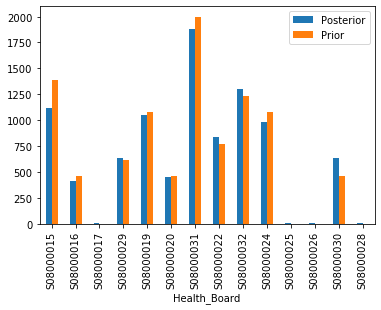

In [41]:
pd.concat([
    summary["best_particle"].inferred_variables["initial-infections"].value.set_index(["Health_Board"])["Infected"].to_frame("Posterior"),
    summary["best_particle"].inferred_variables["initial-infections"].mean.set_index(["Health_Board"])["Infected"].to_frame("Prior")
], axis=1).plot.bar();

# Run with posterior parameters

In [18]:
best_particle = summary["best_particle"]

infection_probability = store.read_table("human/infection-probability", "infection-probability")
infection_probability.at[0, "Value"] = get_param_infection_proba(best_particle)

initial_infections = store.read_table("human/initial-infections", "initial-infections")
initial_infections.Infected = initial_infections.apply(lambda x: get_param_initial_infections(x.Health_Board)(best_particle), axis=1)

network = ss.createNetworkOfPopulation(
    store.read_table("human/compartment-transition", "compartment-transition"),
    store.read_table("human/population", "population"),
    store.read_table("human/commutes", "commutes"),
    store.read_table("human/mixing-matrix", "mixing-matrix"),
    store.read_table("human/infectious-compartments", "infectious-compartments"),
    infection_probability,
    initial_infections,
    store.read_table("human/trials", "trials"),
    store.read_table("human/start-end-date", "start-end-date"),
    store.read_table("human/movement-multipliers", "movement-multipliers"),
    store.read_table("human/stochastic-mode", "stochastic-mode"),
    store.read_table("human/random-seed", "random-seed"),
)
    
results = runSimulation(network)
result = aggregateResults(results)

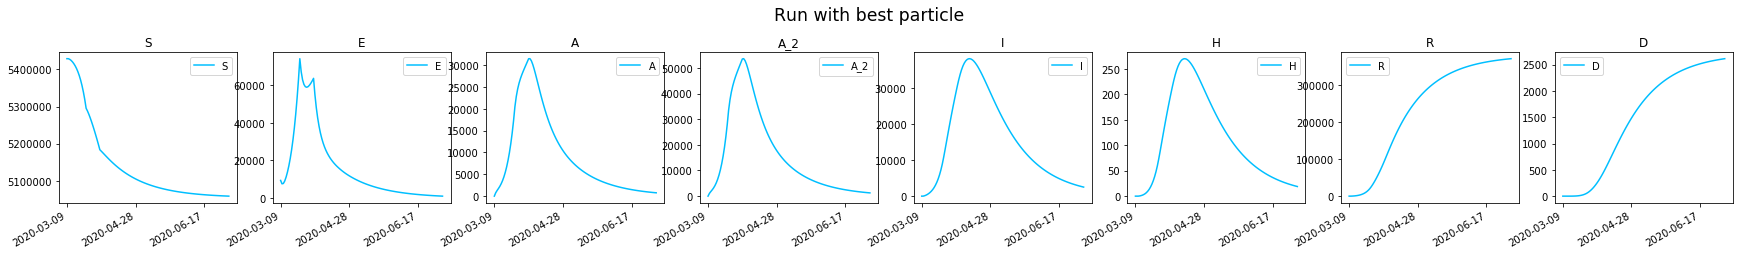

In [22]:
target = aggregate_all_boards(result)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(30, 3.5), sharex=True)
fig.suptitle(f"Run with best particle", fontsize='xx-large')
fig.subplots_adjust(top=0.8)
for i, col in enumerate(['S', 'E', 'A', 'A_2', 'I', 'H', 'R', 'D']):
    try:
        target[col].plot(ax=axes[i], title=col, c="deepskyblue")
        axes[i].legend()
        axes[i].set_xlabel("")
    except:
        pass
    
fig.autofmt_xdate()

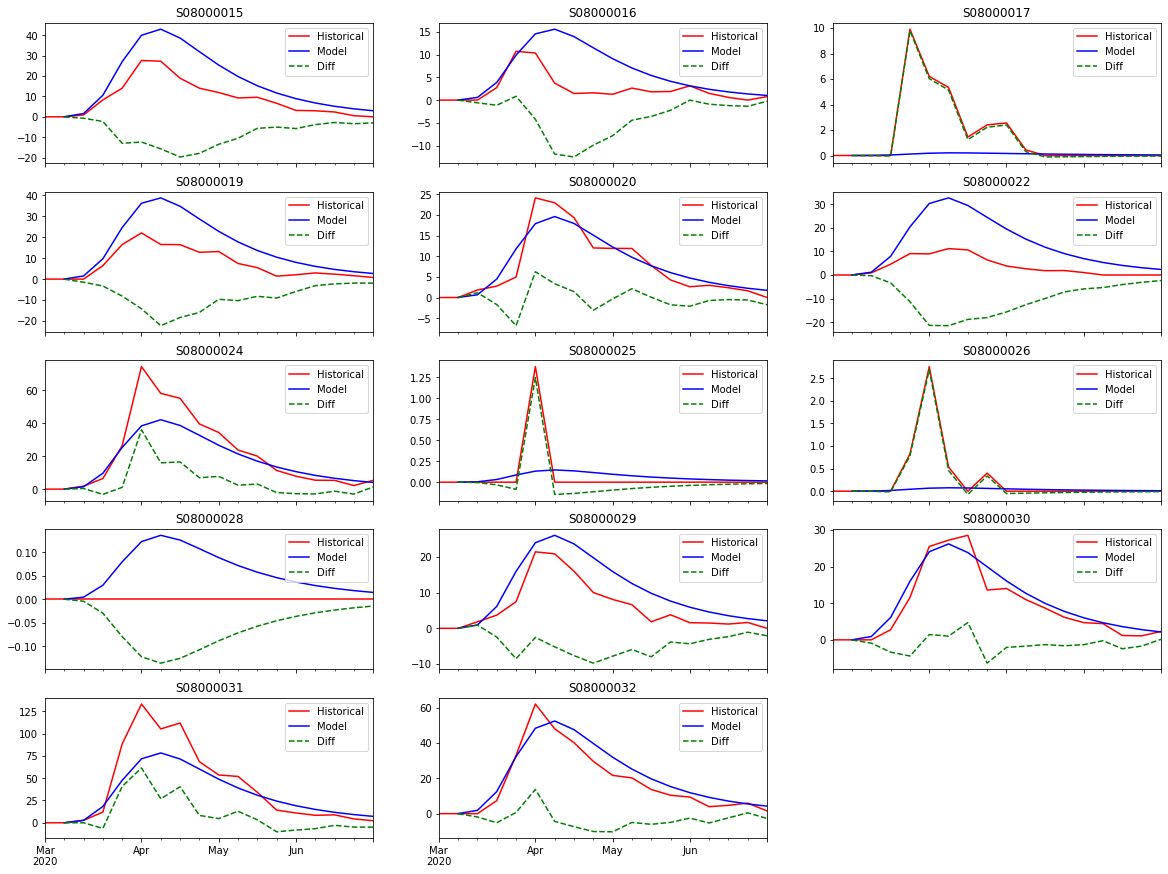

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 15), sharex=True)

result_by_node = (
    result.output
    .query("state == 'D'")
    .groupby(["date", "node"])
    .sum()
    .reset_index()
    .assign(date=lambda x: pd.to_datetime(x.date))
    .pivot(index="date", columns="node", values="total")
    .diff()
    .resample('7D').sum()
    
)
result_by_node.index.name = None
result_by_node.columns.name = None
result_by_node = result_by_node.reindex(sorted(result_by_node.columns), axis=1)

historical = store.read_table("human/historical-deaths", "historical-deaths").set_index("Week beginning")
historical.index = pd.to_datetime(historical.index)
historical = historical.loc["2020-03-02":]
historical.index.name = None
historical = historical.reindex(sorted(historical.columns), axis=1)

for i, hb in enumerate(result_by_node.columns):
    historical[hb].plot(ax=axes[i // 3, i % 3], label="Historical", title=hb, color="red")
    result_by_node[hb].plot(ax=axes[i // 3, i % 3], label="Model", color="blue")
    (historical - result_by_node)[hb].plot(ax=axes[i // 3, i % 3], label="Diff", linestyle="--", color="green")
    axes[i // 3, i % 3].legend()
    
axes[4, 2].remove()